In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver/usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [3]:
import requests
import numpy as np
import pandas as pd
import csv
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
import time
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import re
import traceback

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
options = webdriver.ChromeOptions()
options.add_argument("-headless")
options.add_argument("-no-sandbox")
options.add_argument("-disable-dev-shm-usage")
driver = webdriver.Chrome("chromedriver",options=options)

In [6]:
# scraping reviews
driver.get('https://www.rottentomatoes.com/m/the_batman/reviews')
rows = []
while True:

  page_source = driver.page_source
  soup = BeautifulSoup(page_source,'html.parser')
  
  reviews = soup.find_all("div","row review_table_row")
  #print('New page','*' * 15)
  for review in reviews:
    try:
      
      field = review.find("div","critic_name")
      name = review.find("a").get_text(" ").strip()
      company = review.find("em").get_text(" ").strip()
      #print("name: ",name)
      #print("company: ",company)

      text = review.find("div","the_review").get_text(" ")
      text = text.strip('\r')
      text = text.strip('\n')
      text = text.replace('\n',"").strip()
      #print("review: ",text)
      date = review.find("div","review-date").get_text(" ")
      date = date.strip('\r')
      date = date.strip('\n')
      date = date.replace('\n',"").strip()

      #print("date: ",date)

      tomato = review.find("div","review_icon")['class'][3]
      #print("like: ",tomato)
      rows.append([name,company,date,text,tomato])

      #print("-"*15)

    except:
      print("Exception!")
      pass

  try:
    driver.find_element_by_xpath("//button[@data-qa='next-btn']").click()
    

  except:  
   
    print('Button not found!!')
    break

  finally:
    time.sleep(1)


df = pd.DataFrame(rows,columns=["Name","Publication","Date","Review Text","Rating"])  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead


Button not found!!


In [7]:
df

,Name,Publication,Date,Review Text,Rating
0,Liz Shannon Miller,Consequence,"Mar 19, 2022","What this film does achieve, however, is telli...",fresh
1,Marie Asner,Phantom Tollbooth,"Mar 18, 2022","As for special effects, they are very good, an...",fresh
2,Jana Monji,Age of the Geek,"Mar 18, 2022",How you like this iteration of Batman may depe...,fresh
3,Michael A. Smith,MediaMikes,"Mar 18, 2022","The cast is fine, with Pattinson adding his ow...",fresh
4,Rich Cline,Shadows on the Wall,"Mar 17, 2022","A beefy, stylised approach and committed perfo...",fresh
...,...,...,...,...,...
432,Jake Cole,Slant Magazine,"Feb 28, 2022",The film stands apart for thoughtfully suggest...,fresh
433,Rob Hunter,Film School Rejects,"Feb 28, 2022",The Batman brings the Caped Crusader back to E...,fresh
434,Sheraz Farooqi,CinemaDebate,"Feb 28, 2022","The Batman is bold, brutal and oozes in gothic...",fresh
435,Sean Chandler,Sean Chandler Talks About,"Feb 28, 2022","While it may go on a bit too long, it provides...",fresh


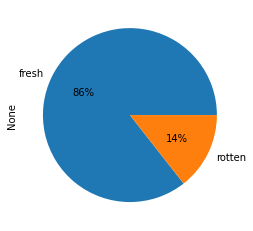

In [9]:
df.groupby(['Rating']).size().plot.pie(autopct='%1.0f%%')

In [ ]:
!pip install datasets transformers[sentencepiece]
!pip3 install emoji
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from scipy.special import softmax

In [11]:
# Hugging face model
MODEL = f"finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

In [12]:
batch = tokenizer(list(df['Review Text']), return_tensors='pt',padding = True, truncation=True)

In [13]:
with torch.no_grad():
  outputs = model(**batch)
  label_ids = torch.argmax(outputs.logits,dim=1)

In [14]:
labels = [model.config.id2label[label_id] for label_id in label_ids.tolist()]

In [15]:
df['sentiment labels'] = labels

In [16]:
df.replace('NEU', 'Neutral',inplace=True)
df.replace('POS', 'Positive',inplace=True)
df.replace('NEG', 'Negative',inplace=True)

In [17]:
df

,Name,Publication,Date,Review Text,Rating,sentiment labels
0,Liz Shannon Miller,Consequence,"Mar 19, 2022","What this film does achieve, however, is telli...",fresh,Positive
1,Marie Asner,Phantom Tollbooth,"Mar 18, 2022","As for special effects, they are very good, an...",fresh,Positive
2,Jana Monji,Age of the Geek,"Mar 18, 2022",How you like this iteration of Batman may depe...,fresh,Negative
3,Michael A. Smith,MediaMikes,"Mar 18, 2022","The cast is fine, with Pattinson adding his ow...",fresh,Neutral
4,Rich Cline,Shadows on the Wall,"Mar 17, 2022","A beefy, stylised approach and committed perfo...",fresh,Positive
...,...,...,...,...,...,...
432,Jake Cole,Slant Magazine,"Feb 28, 2022",The film stands apart for thoughtfully suggest...,fresh,Positive
433,Rob Hunter,Film School Rejects,"Feb 28, 2022",The Batman brings the Caped Crusader back to E...,fresh,Positive
434,Sheraz Farooqi,CinemaDebate,"Feb 28, 2022","The Batman is bold, brutal and oozes in gothic...",fresh,Positive
435,Sean Chandler,Sean Chandler Talks About,"Feb 28, 2022","While it may go on a bit too long, it provides...",fresh,Positive


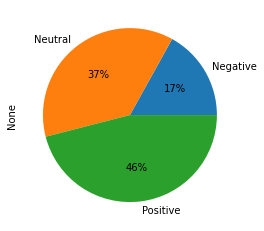

In [18]:
df.groupby(['sentiment labels']).size().plot.pie(autopct='%1.0f%%')

In [19]:
rottenDF = df[df['Rating'] == 'rotten'] # getting only rotten reviews

Text(0.5, 1.0, 'Sentiments for rotten reviews')

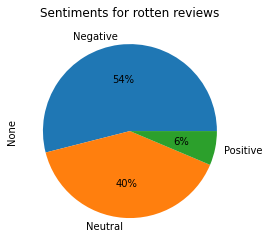

In [20]:
rottenDF.groupby(['sentiment labels']).size().plot.pie(autopct='%1.0f%%')
plt.title('Sentiments for rotten reviews')

In [21]:
freshDF = df[df['Rating'] == 'fresh'] # getting only fresh reviews

Text(0.5, 1.0, 'Sentiments for fresh reviews')

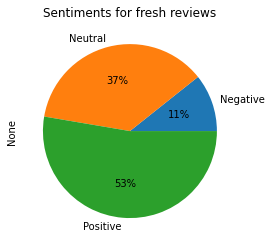

In [23]:
freshDF.groupby(['sentiment labels']).size().plot.pie(autopct='%1.0f%%')
plt.title('Sentiments for fresh reviews')

In [27]:
df_publicationRT = pd.crosstab([df.Publication],df['Rating']).reset_index() # converting to long format for Rating
df_publicationRT.columns.name = 'Index'

In [28]:
df_publicationRT['Total'] = df_publicationRT['fresh'] +df_publicationRT['rotten']
df_publicationRT.sort_values(by='Total',ascending=False,inplace=True)

In [29]:
df_publicationRT

Index,Publication,fresh,rotten,Total
34,Battle Royale With Cheese,3,0,3
119,Film Companion,3,0,3
20,Arkansas Democrat-Gazette,2,1,3
351,The Ringer,2,0,2
333,The Lamplight Review,2,0,2
...,...,...,...,...
136,Fort Worth Weekly,1,0,1
135,Fort Worth Report,1,0,1
133,FlixChatter Film Blog,1,0,1
131,FlickDirect,1,0,1


In [32]:
df_publicationRT[df_publicationRT.rotten == df_publicationRT.Total] # publications which gave only rotten review

Index,Publication,fresh,rotten,Total
233,New Yorker,0,2,2
276,San Francisco Chronicle,0,1,1
264,QiiBO,0,1,1
290,Seattle Times,0,1,1
231,New York Post,0,1,1
217,NBC News THINK,0,1,1
216,My New Plaid Pants,0,1,1
237,Niagara Gazette,0,1,1
259,Polygon,0,1,1
251,Paste Magazine,0,1,1


In [33]:
df_publicationRT[df_publicationRT.rotten == df_publicationRT.Total].shape # finding dimensions

(58, 4)